In [ ]:
# Charger manuellement les données (diabetes.cvs) dans l'environement de travail
from google.colab import files
files.upload()

Saving diabetes.csv to diabetes.csv


{'diabetes.csv': b'Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome\r\n6,148,72,35,0,33.6,0.627,50,1\r\n1,85,66,29,0,26.6,0.351,31,0\r\n8,183,64,0,0,23.3,0.672,32,1\r\n1,89,66,23,94,28.1,0.167,21,0\r\n0,137,40,35,168,43.1,2.288,33,1\r\n5,116,74,0,0,25.6,0.201,30,0\r\n3,78,50,32,88,31,0.248,26,1\r\n10,115,0,0,0,35.3,0.134,29,0\r\n2,197,70,45,543,30.5,0.158,53,1\r\n8,125,96,0,0,0,0.232,54,1\r\n4,110,92,0,0,37.6,0.191,30,0\r\n10,168,74,0,0,38,0.537,34,1\r\n10,139,80,0,0,27.1,1.441,57,0\r\n1,189,60,23,846,30.1,0.398,59,1\r\n5,166,72,19,175,25.8,0.587,51,1\r\n7,100,0,0,0,30,0.484,32,1\r\n0,118,84,47,230,45.8,0.551,31,1\r\n7,107,74,0,0,29.6,0.254,31,1\r\n1,103,30,38,83,43.3,0.183,33,0\r\n1,115,70,30,96,34.6,0.529,32,1\r\n3,126,88,41,235,39.3,0.704,27,0\r\n8,99,84,0,0,35.4,0.388,50,0\r\n7,196,90,0,0,39.8,0.451,41,1\r\n9,119,80,35,0,29,0.263,29,1\r\n11,143,94,33,146,36.6,0.254,51,1\r\n10,125,70,26,115,31.1,0.205,41,1\r\n7,147,76,0,0,39.4,0.257,43

taille des données (768, 9)


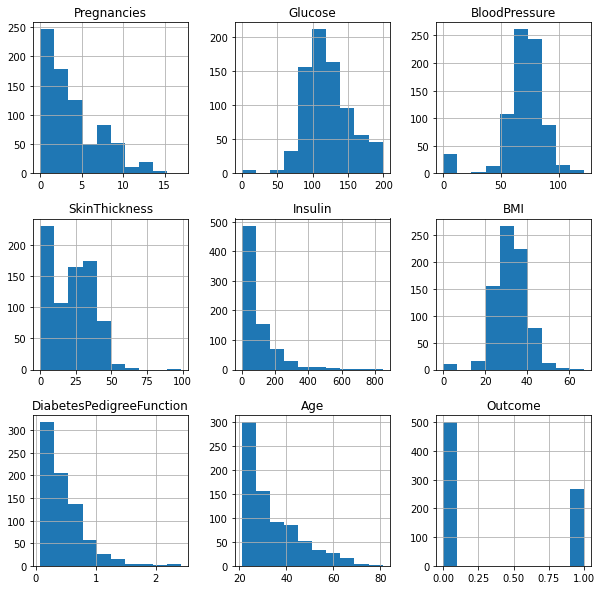

In [ ]:
# Lire les données dans le fichier CSV et les mettre dans un tableau pandas (DataFrame).
# Il permet de plus simplement observer les données qu'un tableau numpy
import pandas as pd

diabetes_initiale_panda = pd.read_csv("diabetes.csv")

# Afficher combien de lignes / colonnes de données nous avons
print("taille des données", diabetes_initiale_panda.shape)

# Afficher l'histogramme des données par colonne
diabetes_initiale_panda.hist(figsize = (10,10));


On voit que l'on a environ 500 personnes qui ne développerons pas la maladie et 280 qui la développerons.
On voit également que certaines données comme l'épaisseur de peau ou l'insuline sont égales à 0 alors que ce n'est pas possible physiologiquement;
Cela vient probablement de données manquantes qui ont été remplacées par des zéro. Il vaut mieux utiliser une marqueur implicite plutôt que 0 qui pourrait être confondu avec une valeur valide.

Regardons tout d'abord combien de lignes ont un problème sur une colonne qui a priori ne peut pas être égale à 0 d'un point de vu physiologique.


In [ ]:
print(diabetes_initiale_panda.query("SkinThickness == 0 or Insulin == 0 or Glucose == 0 or BloodPressure == 0 or BMI == 0").shape[0])

376


Nous avons donc 376 lignes sur 768 soit presque la moitié avec des problèmes.
Nous allons tout d'abord marquer clairement ces données incorrectes en remplacant 0 par np.nan (Not A Number)

In [ ]:
import numpy as np

cols_avec_zeros_incorrects = ["SkinThickness","Insulin","Glucose","BloodPressure","BMI"]
diabetes_panda = diabetes_initiale_panda.copy()
diabetes_panda[cols_avec_zeros_incorrects] = diabetes_panda[cols_avec_zeros_incorrects].replace(0, np.nan)

On voit également que les valeurs sont dans des intervalles très différents par exemple l'épaisseur de peau varie entre 0 et 50, alors que l'insuline varie entre 0 et 800.
Afin de mieux analyser l'impact de chaque parametre (pouvoir les comparer aisément) et de faciliter l'entrainement de certaines modèles comme les réseaux de neurones, il est conseillé de normaliser les valeurs d'entrée:

$norm(x_i) = \frac{(x_i - \bar{x})}{σ_x} $

Cette formule centre les valeurs sur 0 et concentre la plupart des valeurs entre -1 et 1 (en tout cas quand les valeurs ont une distribution normalisé ce qui n'est pas le cas par exemple de l'age ou de l'insuline)

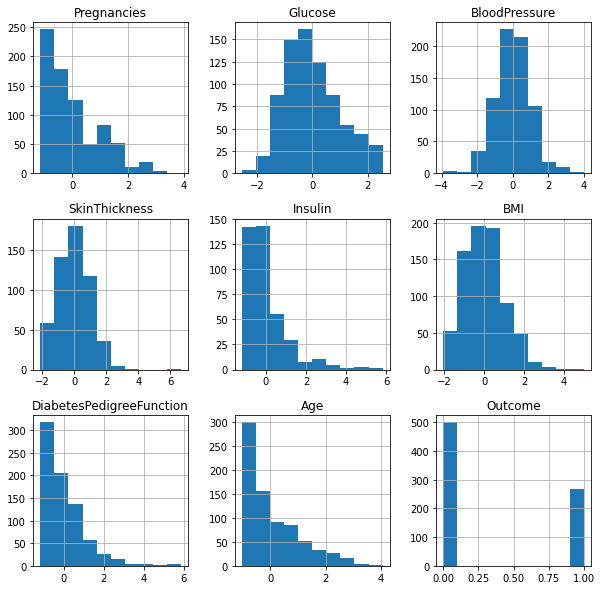

In [ ]:
# .mean() et .std() ignorent bien les valeurs NaN, on le fait sur toutes les colonnes sauf outcome
diabates_normalisees_sans_outcome = diabetes_panda.drop(["Outcome"], axis=1)
diabates_normalisees_panda = (diabates_normalisees_sans_outcome - diabates_normalisees_sans_outcome.mean()) / diabates_normalisees_sans_outcome.std()
diabates_normalisees_panda["Outcome"] = diabetes_panda["Outcome"]

diabates_normalisees_panda.hist(figsize = (10,10));

Nous allons dans un premier temps réserver 75% des données à l'entrainement et 25% pour tester la pertinence du résultat obtenu.

In [ ]:
# La partition entre entrainement et test étant faite "au hasard", nous initialisons le générateur de nombre aléatoire
# au même état (random_state) afin d'obtenir toujours le même résultat
# 75% des données sont utilisés pour l'entrainement et le reste pour le test
diabetes_normalisees_panda_entrainement = diabates_normalisees_panda.sample(frac=0.75,random_state=10)
diabetes_normalisees_panda_test = diabates_normalisees_panda.drop(diabetes_normalisees_panda_entrainement.index)

Il existe plusieurs approches pour traiter les données incorrectes, l'une d'elle est de tout simplement les supprimer, panda possède un methode simple $dropna$ pour les supprimer.
L'inconvénient c'est que l'on possède moins de données pour entrainer l'algorithme et qu'il pourrait donc être moins performant. Cela est toute fois préférable à entrainer à partir de données fausses/manquantes quand l'algorithme ne supporte pas les données manquantes.

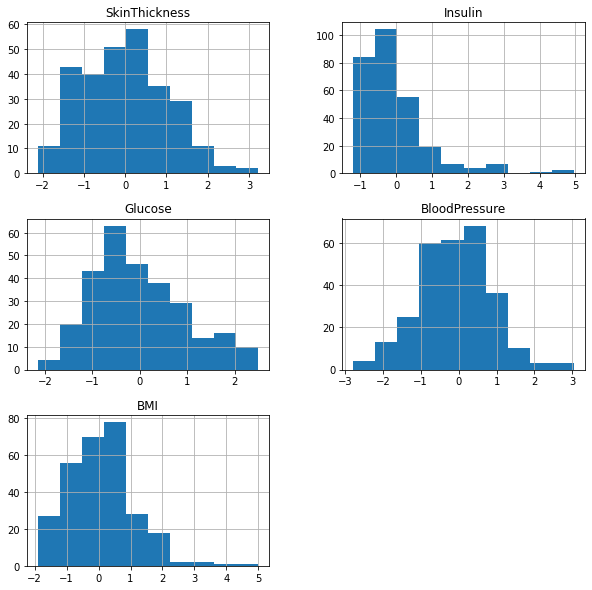

In [ ]:
# on enleve les données avec nan
diabetes_normalisees_clean_panda_entrainement = diabetes_normalisees_panda_entrainement.dropna()
diabetes_normalisees_clean_panda_test = diabetes_normalisees_panda_test.dropna()

diabetes_normalisees_clean_panda_entrainement.hist(figsize = (10,10), column=cols_avec_zeros_incorrects);

On voit bien maintenant que aucune donnée n'est égale à 0. Pour faciliter les calculs, on peut maintenant a partir des $DataFrame$ $panda$ récuperer des matrices $numpy$

In [ ]:
diabates_normalisees_clean_entrainement = diabetes_normalisees_clean_panda_entrainement.values
diabates_normalisees_clean_test = diabetes_normalisees_clean_panda_test.values

In [ ]:
# 8 premières colonnes : les données, et la dernière colonne le résultat
X_entrainement = diabates_normalisees_clean_entrainement[:,:8]
y_entrainement = diabates_normalisees_clean_entrainement[:,8]

X_test = diabates_normalisees_clean_test[:,:8]
y_test = diabates_normalisees_clean_test[:,8]

Nous allons tout d'abord essayer de prédire la survenue du diabète dans les 5 ans à l'aide d'une regression logistique. C'est à dire que nous allons à partir des échantillons de données essayer de trouver une fonction de la forme $h(x)=\frac{1}{(1+e^{\theta^Tx})}$. Pour trouver cette fonction (et donc la valeur de $\theta$ nous allons essayer de minimiser une fonction de cout $$J(\theta) = \frac{1}{m}\sum_{i=0}^{m-1}[(y^{(i)}-1)log(1-h_\theta(x^{(i)})) - y^{(i)}log(h_\theta(x^{(i)})]$$ en utilisant la descente du gradient pour cela nous calculons la dérivée partielle de $J(\theta)$ par rapport à chaque $\theta$ en version vectorisée: $X^T(h(X) - y)$

In [ ]:
theta_initiale = np.full(X_entrainement.shape[1]+1, 1)   # 9 = 8 colonnes + 1 theta0
alpha = 0.1                      # taux d'apprentissage
colonne1 = np.full((X_entrainement.shape[0], 1), 1)      # on rajoute une colonne de 1 pour le biais
X_entrainement_avec_biais = np.hstack((colonne1, X_entrainement))
colonne1 = np.full((X_test.shape[0], 1), 1)  # pareil
X_test_avec_biais = np.hstack((colonne1, X_test))

# implementation vectorisée, cela marche quelque soit la dimension de z
def sigmoide(z):
  return 1 / (1+np.exp(-z))

# renvoie les theta finaux après l'entrainement
def entrainement(theta_init, X, y, alpha, max_iteration):
  m = X.shape[0]             # nombres de personnes utilisées dans l'entrainement
  theta = theta_init.copy()
  for k in range(max_iteration):
    # np.matmul(X.T, sigmoide(np.matmul(X,theta))-y) représente les dérivées
    # partielles de la fonction de cout
    theta = theta - (alpha/m)*np.matmul(X.T, sigmoide(np.matmul(X, theta)) - y)
  return theta

# on appelle la fonction d'entrainement pour calculer les thetas finaux
theta_finale = entrainement(theta_initiale, X_entrainement_avec_biais, y_entrainement, alpha, 50000)

In [ ]:
# limite de la prédiction ici à 1/2
def prediction_discrete(x):
  # si x >= 0.5 on prédit "vrai"
  if x >= 0.5:
    return 1
  else:
    # sinon faux
    return 0

In [ ]:
# fonction de prédiction
def prediction(X, theta):
  resultat = sigmoide(np.matmul(X, theta))     #matmul
  for k in range(len(resultat)):
    resultat[k] = prediction_discrete(resultat[k])
  return resultat

# fonction qui compare les résultats obtenus et attendus et renvoit
# le nombre de résultats corrects sur le nombre total
def comparaison_resultat(resultat, Y):
  S = 0
  for k in range(len(resultat)):
    if resultat[k] == Y[k]:
      S = S + 1
  return S / len(Y)

In [ ]:
print(theta_finale)
comparaison_resultat(prediction(X_test_avec_biais, theta_finale), y_test)

[-0.89310461  0.45911059  1.2015467   0.05938943  0.12962825 -0.09888017
  0.32702918  0.50967464  0.21342774]


0.8073394495412844

Les valeurs de $\theta$ les plus importantes en valeur absolues correpondent aux paramètres d'entrée qui ont le plus d'influence sur la prédidction. On note que le taux de glucose (sucre) est le paramètre le plus important (ce qui semble logique le diabiète étant une maladie de l'assimilation du sucr), suivit du facteur famillial (diabètiques dans la famille) et du nombre de grossesses. A contrario, la pression sanguine et l'insuline n'on quasiment pas d'influence.

Cette "simple" regression logistique prédit déjà un résultat correct à 80.7%.

In [ ]:
# fonction quadratique : x1,x1**2, x1x2
import math
def transformation_quadratique(X):
  shape = X.shape[1] - 1
  for i in range(shape):
    for j in range(i, shape):
      X = np.hstack((X, np.multiply(X[:,i+1:i+2],X[:,j+1:j+2])))
  return X

X_entrainement_avec_biais_quad = transformation_quadratique(X_entrainement_avec_biais)

In [ ]:
# on recrée des nouvelles matrices d'entrainement adapté
theta_initiale_quad = np.full(X_entrainement_avec_biais_quad.shape[1], 1)
theta_finale_quad = entrainement(theta_initiale_quad, X_entrainement_avec_biais_quad, y_entrainement, alpha, 50000)
X_test_with_bias_quad = transformation_quadratique(X_test_avec_biais)
comparaison_resultat(prediction(X_test_with_bias_quad, theta_finale_quad), y_test)



0.7706422018348624

Introduire une fonction quadratique donne en pratique un moins bon résultat puisque de "seulement" 77%. C'est du au fait que la fonction s'est trop adapté aux données d'entrainement, on a fait du "sur apprentissage".

In [ ]:
# regularisation : rajoute une erreur pour essayer de redevenir générale et
# corriger le sur apprentissage
def entrainement_regularisation(theta_initiale, X, y, alpha, la, max_iteration):
  # nombres d'échantillons de données (personnes)
  m = X.shape[0]
  theta = theta_initiale.copy()
  for k in range(max_iteration):
    # on applique pas la regularisation au biais
    theta_reg = np.append(np.array([0]), theta[1:])
    theta = theta - (alpha/m)*(np.matmul(X.T, sigmoide(np.matmul(X, theta)) - y) + la*theta_reg)
  return theta

theta_finale_quad_reg = entrainement_regularisation(theta_initiale_quad, X_entrainement_avec_biais_quad, y_entrainement, alpha, 100, 50000)
resultat = prediction(X_test_with_bias_quad,theta_finale_quad_reg)
comparaison_resultat(resultat, y_test)



0.8165137614678899

In [ ]:
def precision(resultat, Y):
  S_predit_positif_correct = 0
  S_predit_positif = 0
  for k in range(len(resultat)):
    if resultat[k] == 1:
      S_predit_positif = S_predit_positif + 1
      if Y[k] == 1:
         S_predit_positif_correct = S_predit_positif_correct + 1
  return S_predit_positif_correct / S_predit_positif

def rappel(resultat, Y):
  S_predit_positif_correct = 0
  S_positif = 0
  for k in range(len(resultat)):
    if Y[k] == 1:
      S_positif = S_positif + 1
      if resultat[k] == 1:
         S_predit_positif_correct = S_predit_positif_correct + 1
  return S_predit_positif_correct / S_positif

print(precision(resultat, y_test))
print(rappel(resultat, y_test))



0.8181818181818182
0.5294117647058824


En introduisant une grosse regularisation on obtient un meilleur résultat et l'on atteint 81.65% d'exactitude.

Après la regression logistique essayons les réseaux de neurones.


In [ ]:
# on fixe la graine du générateur aléatoire pour pouvoir retourner le code avec des
# valeurs identiques
generateur_aleatoire = np.random.default_rng(10)

# architecture du réseau de neurones, une entrée par couche
# pour chaque entrée
#  * dimension 1 (lignes) = dimension du niveau
#  * dimension 2 (colonnes) = dimension du niveau précédent + 1 (biais)
# pour une classification binaire il y a toujours une sortie de dimension 1
THETAS_2_COUCHES_INITIALES = [generateur_aleatoire.random((5, X_entrainement_avec_biais.shape[1])),
                              generateur_aleatoire.random((1, 5+1))]
THETAS_3_COUCHES_INITIALES = [generateur_aleatoire.random((6, X_entrainement_avec_biais.shape[1])),
                              generateur_aleatoire.random((3, 6+1)),
                              generateur_aleatoire.random((1, 3+1))]

# la combinaison linéaire
def z_f(THETA, X):
  return np.matmul(X, THETA.T)

# on avance dans le réseau de neurones pour prédire une valeur à partir des
# matrices THETAS
def propagation(THETAS, X, activation_f):
  # L = nombre de couches dans l'architecture du réseau de neurons
  L = len(THETAS)
  # ZS = les combinaisons lineaires pour chaque couche
  ZS = [ ]
  # AS = les valeurs d'activations pour chaque couche
  AS = [ ]
  # on commence avec les valeurs d'entrée
  a = X
  for l in range(L-1):
    # calcul de valeurs d'activation pour la couche l à partir des valeurs
    # de la couche précédente
    z = z_f(THETAS[l], a)
    a = activation_f(z)
    # on rajoute une colonne de 1 dans les valeurs d'activation pour le biais
    # de la couche suivante
    colonne1 = np.full((a.shape[0], 1), 1)
    a = np.hstack((colonne1, a))
    # il n'existe pas de z pour le biais, on rajoute une colonne de 0
    colonne0 = np.full((z.shape[0], 1), 0)
    z = np.hstack((colonne0, z))
    AS.append(a)
    ZS.append(z)

  # la dernière couche donne la valeur prédite, dans notre cas
  z = z_f(THETAS[L-1], a)
  h = sigmoide(z)
  # dernière couche donc pas besoin de rajoute de biais pour la suivante
  AS.append(h)
  ZS.append(z)
  # on retourne un tableau de valeurs prédites et les combinaisons linéaires et les
  # valeurs d'activation de chaque couche qui pourront être utiles pour la retro
  # propagation
  return h, ZS, AS


Pour un réseau de neurones, la fonction de cout est plus compliquée, avec $m$ le nombre d'échantillons de données, $\lambda$ le facteur de régularisation, $S_i^{(l)}$ et $S_j^{(l)}$ le nombre de lignes et de colonnes de $\Theta^{(l)}$ :
$$
J(\Theta) = \frac{1}{m}\left(\sum_{i=0}^{m-1} (y^{(i)}-1)log(1-h_\theta(x^{(i)})) - y^{(i)}log(h_\theta(x^{(i)})) +  \frac{\lambda}{2}\sum_{n=0}^{L-1}\sum_{i=0}^{S_i^{(l)}-1}\sum_{j=1}^{S_j^{(l)}-1}(\Theta_{i,j}^{(l)})^2\right)
$$



In [ ]:
# calcul du terme de régularisation L2 sur les valeurs de thetas
def omega(THETAS):
  # L = nombre de couches dans l'architecture du réseau de neurones
  L = len(THETAS)
  omega = 0
  for l in range(L):
    for i in range(THETAS[l].shape[0]):
      # on saute les colonnes de biais car on ne les régularise pas
      for j in range(1, THETAS[l].shape[1]):
        omega += THETAS[l][i][j]**2
  return omega / 2

# calcul du cout (erreur) pour un ensemble de données (X) par rapport aux valeurs
# attentues (y), avec une régularisation de facteur "la" (lambda)
def J(THETAS, X, y, la, activation_f):
  cout = 0
  regularisation = 0
  # m = nombres d'échantillons de données (personnes)
  m = X.shape[0]

  # calcul des valeurs prédites
  h = propagation(THETAS, X, activation_f)[0]

  # calcul du cout hors regularisation
  for i in range(m):
    cout += (y[i]-1)*np.log(1-h[i]) - y[i]*np.log(h[i])

  # calcul de la pénalité de regularisation de facteur lambda
  regularisation = la*omega(THETAS)

  # cout total pondéré par le nombre d'échantillons
  return (cout + regularisation) / m

La retro propagation est une technique efficace numériquement parlant pour calculer les dérivées partielles de $J(\Theta)$ par rapport à chacun des $\Theta_{i,j}^{(l)}$. Nous validons son implementation par rapport à une approximation numerique traditionelle de la dérivée $\frac{\partial J(\Theta)}{\partial \Theta_{i,j}^{(l)}}\approx\frac{J(\Theta_{0,0}^{(0)},\cdots,\Theta_{i,j}^{(l)}+\epsilon,\cdots)-J(\Theta_{0,0}^{(0)},\cdots,\Theta_{i,j}^{(l)}-\epsilon,\cdots)}{2\epsilon}$

Dans notre cas la fonction d'activation de chaque neurones est la fonction sigmoide déjà utilisée pour la regression logistique.

In [ ]:
import time

# la dérivée de la sigmoide(z) est sigmoide(z)*(1-sigmoide(z)), mais il n'est
# pas la peine de la recalculer entièrement car a = sigmoide(z)
def derivee_sigmoide(a, z):
  return a*(1-a) # sigmoide(z)*(1-sigmoide(z))

# la retro propagation caclcule la dérivée partielle de J par rapport à chaque
# theta en parcourant le réseau de neurones en sens inverse et en utilisant
# un chainage de dérivées partielles
def retro_propagation(THETAS, X, y, la, activation_f, derivee_activation_f):
  # m = nombres d'échantillons de données (personnes)
  m = X.shape[0]
  # L = nombre de couche dans l'architecture du réseau de neurones
  L = len(THETAS)
  # DELTA contiendra la somme de dérivées partielles par rapport à chaque theta
  # en ignorant la régularisation pour toutes les échantillons
  DELTA = [ np.zeros(THETAS[l].shape) for l in range(L) ]
  # delta contiendra les "erreurs" pour chaque couche du réseau
  # la première couche (index 0) ne sera pas rempli (pas d'erreur)
  delta = [None]*(L+1)

  for i in range(m):
    # on appelle d'abord propagation pour chaque échantillon de données
    # pour récuperer les valeurs d'activation pour chaque couche
    X_i = X[i:i+1,]
    (_, z, a) = propagation(THETAS, X_i, activation_f)
    # on rajoute aux valeurs d'activation de chaque couche les valeurs
    # de départ (pour le niveau 0)
    a.insert(0, X_i)
    # l'erreur de la dernière couche est la différence entre la valeur dans la
    # dernière couche (la valeur finale) et la valeur attendue (y)
    delta[L] = a[L] - y[i]

    # on parcours l'architecture du réseau à l'envers sauf les valeurs
    # d'entrés
    for l in reversed(range(1, L)):
      # l'erreur sur une couche non terminale est fonction de l'erreur de la
      # couche précédente, des thetas de la couche et de la dérivée de la
      # fonction d'activation
      delta[l] = np.matmul(delta[l+1], THETAS[l])*derivee_activation_f(a[l], z[l-1])
      # on enlève la colonne de biais avant de passer au niveau précédent
      delta[l] = delta[l][:,1:]

    for l in range(L):
      # on sommes tous les échantillons
      DELTA[l] = DELTA[l] + np.matmul(a[l].T, delta[l+1]).T

  # on divise par le nombre d'échantillons et on rajoute la dérivée du biais
  # D[l] contient alors la dérivée partielle de J par rapport à chacun des
  # thetas du niveau l
  D = [ np.zeros(THETAS[l].shape) for l in range(L) ]
  for l in range(L):
      for i in range(DELTA[l].shape[0]):
        for j in range(DELTA[l].shape[1]):
          if j!=0:
            D[l][i][j] = (DELTA[l][i][j] + la*THETAS[l][i][j]) / m
          else:
            D[l][i][j] = DELTA[l][i][j]/m

  return D

# la méthode numérique calcule une approximation de la dérivée de J par rapport
# à chaque theta
def calcul_numerique_gradient(THETAS, X, y, la, activation_f):
   # epsilon = précision de calcul de l'approximation de la dérivée
  epsilon = 0.0001
  # L = nombre de couche dans l'architecture du réseau de neurones
  L = len(THETAS)
  APPROXVECTOR = np.array([])
  for l in range(L):
    APPROX = np.zeros(THETAS[l].shape)
    for i in range(THETAS[l].shape[0]):
      for j in range(THETAS[l].shape[1]):
        THETAPLUS = [ THETAS[l].copy() for l in range(L) ]
        THETAPLUS[l][i][j] = THETAS[l][i][j] + epsilon
        THETAMOINS = [ THETAS[l].copy() for l in range(L) ]
        THETAMOINS[l][i][j] = THETAS[l][i][j] - epsilon
        APPROX[i][j] = (J(THETAPLUS, X, y, la, activation_f) - J(THETAMOINS, X, y, la, activation_f))/(2*epsilon)
    APPROXVECTOR = np.concatenate((APPROXVECTOR, APPROX.ravel()))
  return APPROXVECTOR

def verification_gradient(THETAS, X, y, la, activation_f, derivee_activation_f):
  # L = nombre de couche dans l'architecture du réseau de neurones
  L = len(THETAS)
  DVECTOR = np.array([])
  # calcul par approximation numérique
  now = time.time()
  APPROXVECTOR = calcul_numerique_gradient(THETAS, X, y, la, activation_f)
  num = time.time() - now
  print("durée approximation", num)
  # calcul par retro propagation
  now = time.time()
  D = retro_propagation(THETAS, X, y, la, activation_f, derivee_activation_f)
  retro = time.time() - now
  print("durée retro propagation", retro)
  print("la méthode par retro propagation est {} plus rapide".format(num/retro))
  for l in range(L):
    DVECTOR = np.concatenate((DVECTOR, D[l].ravel()))
  # on compare la similarité des vecteurs des deux solutions en utilisant
  # la norme, il faut que le resultat soit proche de zero
  DIFF = np.linalg.norm(DVECTOR - APPROXVECTOR) / np.linalg.norm(DVECTOR + APPROXVECTOR)
  return DIFF

THETAS_TEST_GRADIENT = [
                         np.array([math.sin(idx+1) / 10 for idx in range(45)]).reshape(5, 8+1),
                         np.array([math.sin(idx+1) / 10 for idx in range(18)]).reshape(3, 5+1),
                         np.array([math.sin(idx+41) / 10 for idx in range(4)]).reshape(1, 3+1)
]

print(verification_gradient(THETAS_TEST_GRADIENT, X_entrainement_avec_biais, y_entrainement, 0.1, sigmoide, derivee_sigmoide))

durée approximation 0.4060380458831787
durée retro propagation 0.023440837860107422
la méthode par retro propagation est 17.321823063935394 plus rapide
8.346104952100739e-11


Le calcul des dérivées partielles par retro propagation est validée. On note qu'elle est 18 fois plus rapide que part approximation numérique classique.

Une fonction d'activation alternative à la sigmoide est la fonction LeakyReLU dont la définition est $f(x)=max(x, ϵx)$. Dans notre cas on pose $\epsilon=0.01$

In [ ]:
# fonction d'activation de neurones, "unité linéaire rectifiée"
def LeakyReLU(z):
  # version vectorisée, marche aussi bien sur un réel qu'un vecteur
  return np.maximum(z, 0.01*z)

def derivee_LeakyReLUReel(z):
  # la dérivée de LeakyRELu est 1 si x > 0 et 0.1 si x <= 0
  if z > 0:
    return 1
  else:
    return 0.01

def derivee_LeakyReLU(a, z):
  # quand la fonction qu'on utilie n'existe pas en version vectorisée de numpy
  # on peut en créer une version vectorisée
  derivee_vectorise = np.vectorize(derivee_LeakyReLUReel)
  return derivee_vectorise(z)

THETAS_TEST_GRADIENT = [
                         np.array([math.sin(idx+1) / 10 for idx in range(45)]).reshape(5, 8+1),
                         np.array([math.sin(idx+1) / 10 for idx in range(18)]).reshape(3, 5+1),
                         np.array([math.sin(idx+41) / 10 for idx in range(4)]).reshape(1, 3+1)
]

print(verification_gradient(THETAS_TEST_GRADIENT, X_entrainement_avec_biais, y_entrainement, 0.1, LeakyReLU, derivee_LeakyReLU))

durée approximation 0.39662623405456543
durée retro propagation 0.034964561462402344
la méthode par retro propagation est 11.34366391184573 plus rapide
1.6219416891860583e-05


In [ ]:
def descente_gradient(THETAS_INIT, X, y, alpha, la, max_iteration, activation_f, derivee_activation_f):
  m = X.shape[0]            # nombres de personnes utilisées dans l'entrainement
  L = len(THETAS_INIT)
  # copie de THETAS_INIT
  THETAS = [ THETAS_INIT[l].copy() for l in range(L) ]
  for k in range(max_iteration):
    # on utilise la retro propagation pour calculer les dérivées partielles
    # de J par rapport aux thetas
    D = retro_propagation(THETAS, X, y, la, activation_f, derivee_activation_f)
    for l in range(L):
      THETAS[l] = THETAS[l] - alpha*D[l]
    # affiche l'évolution de la valeur de la fonction de cout toutes les 100 itérations
    # if k%100==0:
    # print(J(THETAS, X, y, la, activation_f))
  return THETAS

In [ ]:
THETAS_SIGMOIDE = descente_gradient(THETAS_3_COUCHES_INITIALES, X_entrainement_avec_biais, y_entrainement, 0.1, 0.01, 5000, sigmoide, derivee_sigmoide)

In [ ]:
def prediction_reseau_neurone(TRAINED_THETAS, X, activation_f):
  (y, _, _) = propagation(TRAINED_THETAS, X, activation_f)
  for k in range(len(y)):
    y[k] = prediction_discrete(y[k])
  return y

comparaison_resultat(prediction_reseau_neurone(THETAS_SIGMOIDE, X_test_avec_biais, sigmoide), y_test)

0.7889908256880734

In [ ]:
THETAS_LEAKY_RELU = descente_gradient(THETAS_3_COUCHES_INITIALES, X_entrainement_avec_biais, y_entrainement, 0.1, 1, 20000, LeakyReLU, derivee_LeakyReLU)



In [ ]:
resultat = prediction_reseau_neurone(THETAS_LEAKY_RELU, X_test_avec_biais, LeakyReLU)

print(comparaison_resultat(resultat, y_test))
print(precision(resultat, y_test))
print(rappel(resultat, y_test))


0.8165137614678899
0.6842105263157895
0.7647058823529411


En executant le code précédent avec différent paramètres voici les résultats, le meilleur résultat est obtenu avec un réseau à 3 couches, utilisant LeakyReLU.

|Couche de neurones|Fonction d'activation|lambda|max_iteration|résultat|pourcentage de données utilisées pour l'entrainement|
|------------------|---------------------|------|-------------|--------|-----|
|2|LeakyReLU|0.01|5000|79.81%|75%|
|2|LeakyReLU|1|5000|75.22%|75%|
|2|LeakyReLU|1|20000|75.22%|75%|
|3|LeakyReLU|0.01|5000|72.47%|75%|
|3|LeakyReLU|1|5000|77.06%|75%|
|3|LeakyReLU|1|10000|79.81%|75%|
|**3**|**LeakyReLU**|**1**|**20000**|**81.65%**|**75%**|
|2|Sigmoide|0.01|5000|78.89%|75%|
|2|Sigmoide|1|5000|77.98%|75%|
|2|Sigmoide|1|20000|77.98%|75%|
|3|Sigmoide|0.01|5000|79.81%|75%|
|3|Sigmoide|1|5000|79.81%|75%|
|3|Sigmoide|1|20000|79.81%|75%|
|3|Sigmoide|0.01|5000|77.56%|50%|
|3|LeakyReLU|1|5000|71.70%|50%|



Régression logistique :

|lambda|max_iteration|résultat|pourcentage de données utilisée pour l'entrainement|quadratique|
|------------------|---------------------|------|-------------|----|
|0|50000|76.58%|50%|non|
|0|50000|75.12%|50%|oui|
|100|50000|74.63%|50%|oui|
|0|50000|80.73%|75%|non|
|0|50000|77.06%|75%|oui|
|**100**|**50000**|**81.65%**|**75%**|**oui**|



In [ ]:
# Charger manuellement les données (processed.cleveland.data) dans l'environement de travail
from google.colab import files
files.upload()

In [ ]:
maladie_cardiaque_initiale_panda = pd.read_csv("processed.cleveland.data", header=None,
                                              names=["age","sex","cp","trestbps","chol","fbs",
                                                     "restecq","thalach","exang","oldpeak",
                                                     "slope","ca","thal","diagnosis"])

print(maladie_cardiaque_initiale_panda)
print("taille des données", maladie_cardiaque_initiale_panda.shape)

# certaines données ont été remplacé par des ?, on supprime les lignes correspodantes
maladie_cardiaque_panda = maladie_cardiaque_initiale_panda.replace({'?': np.nan}).dropna().astype(float)

# Afficher l'histogramme des données par colonne
maladie_cardiaque_panda.hist(figsize = (10,10))

In [ ]:
maladie_cardiaque_normalisees_sans_diagnosis = maladie_cardiaque_panda.drop(["diagnosis"], axis=1)
maladie_cardiaque_normalisees_panda = (maladie_cardiaque_normalisees_sans_diagnosis - maladie_cardiaque_normalisees_sans_diagnosis.mean()) / maladie_cardiaque_normalisees_sans_diagnosis.std()
maladie_cardiaque_normalisees_panda["diagnosis"] = maladie_cardiaque_panda["diagnosis"]

# comme nous faisons de la classification binaire, on veut un diagnostique 0 = pas malade, 1 = malade
# donc on transforme les différent niveaux de maladie 1, 2, 3 et 4 en 1.
maladie_cardiaque_normalisees_panda["diagnosis"].replace([0, 1, 2, 3, 4], [0, 1, 1, 1, 1], inplace=True)


maladie_cardiaque_normalisees_panda.hist(figsize = (10,10));

In [ ]:
maladie_cardiaque_normalisees_panda_entrainement = maladie_cardiaque_normalisees_panda.sample(frac=0.75,random_state=10)
maladie_cardiaque_normalisees_panda_test = maladie_cardiaque_normalisees_panda.drop(maladie_cardiaque_normalisees_panda_entrainement.index)

In [ ]:
maladie_cardiaque_normalisees_entrainement = maladie_cardiaque_normalisees_panda_entrainement.values
maladie_cardiaque_normalisees_test = maladie_cardiaque_normalisees_panda_test.values

In [ ]:
X_entrainement = maladie_cardiaque_normalisees_entrainement[:,:13]
y_entrainement = maladie_cardiaque_normalisees_entrainement[:,13]

X_test = maladie_cardiaque_normalisees_test[:,:13]
y_test = maladie_cardiaque_normalisees_test[:,13]

colonne1 = np.full((X_entrainement.shape[0], 1), 1)      # on rajoute une colonne de 1 pour le biais
X_entrainement_avec_biais = np.hstack((colonne1, X_entrainement))
colonne1 = np.full((X_test.shape[0], 1), 1)  # pareil
X_test_avec_biais = np.hstack((colonne1, X_test))

In [ ]:
X_entrainement_avec_biais_quad = transformation_quadratique(X_entrainement_avec_biais)
theta_initiale_quad = np.full(X_entrainement_avec_biais_quad.shape[1], 1)
X_test_with_bias_quad = transformation_quadratique(X_test_avec_biais)
theta_finale_quad_reg = entrainement_regularisation(theta_initiale_quad, X_entrainement_avec_biais_quad, y_entrainement, 0.1, 10, 50000)
resultat = prediction(X_test_with_bias_quad,theta_finale_quad_reg)
print(comparaison_resultat(resultat, y_test))
print(precision(resultat, y_test))
print(rappel(resultat, y_test))

In [ ]:
THETAS_3_COUCHES_INITIALES = [generateur_aleatoire.random((7, X_entrainement_avec_biais.shape[1])),
                              generateur_aleatoire.random((3, 7+1)),
                              generateur_aleatoire.random((1, 3+1))]

THETAS_2_COUCHES_INITIALES = [generateur_aleatoire.random((6, X_entrainement_avec_biais.shape[1])),
                              generateur_aleatoire.random((1, 6+1))]

THETAS_4_COUCHES_INITIALES = [generateur_aleatoire.random((10, X_entrainement_avec_biais.shape[1])),
                              generateur_aleatoire.random((6, 10+1)),
                              generateur_aleatoire.random((3, 6+1)),
                              generateur_aleatoire.random((1, 3+1))]
THETAS_LEAKY_RELU = descente_gradient(THETAS_4_COUCHES_INITIALES, X_entrainement_avec_biais, y_entrainement, 0.1, 1, 20000, LeakyReLU, derivee_LeakyReLU)

print(comparaison_resultat(prediction_reseau_neurone(THETAS_LEAKY_RELU, X_test_avec_biais, LeakyReLU), y_test))

In [ ]:
THETAS_SIGMOIDE = descente_gradient(THETAS_3_COUCHES_INITIALES, X_entrainement_avec_biais, y_entrainement, 0.1, 1, 20000, sigmoide, derivee_sigmoide)


In [ ]:
resultat = prediction_reseau_neurone(THETAS_SIGMOIDE, X_test_avec_biais, sigmoide)
print(comparaison_resultat(resultat, y_test))
print(precision(resultat, y_test))
print(rappel(resultat, y_test))

|Couche de neurones|Fonction d'activation|lambda|max_iteration|résultat|pourcentage de données utilisées pour l'entrainement|
|------------------|---------------------|------|-------------|--------|-----|
|3|LeakyReLU|0.01|5000|75.67%|75%|
|3|LeakyReLU|1|20000|82.42%|75%|
|2|LeakyReLU|1|20000|81.08%|75%|
|4|LeakyReLU|1|20000|79.72%|75%|
|3|sigmoide|0.01|5000|82.43%|75%|
|3|sigmoide|1|20000|79.72%|75%|


Régression logistique :

|lambda|max_iteration|résultat|pourcentage de données utilisée pour l'entrainement|quadratique|
|------------------|---------------------|------|-------------|----|
|100|50000|79.72%|75%|oui|
|10|50000|78.37%|75%|oui|
